In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from Helper.shue_model import shue_magnetopause_surface, shue_magnetopause_xz, shue_magnetopause_xy, shue_magnetopause_yz
import pyspedas
from pyspedas import get_data
from Helper.shue_model import filter_train_samples_by_time, shue_radius_at_x
from Helper.plotting import plot_variables_from_sections
from Helper.moon import lunar_wake_check_series
from Helper.silence import retry_request
from pyspedas import tplot
from data_loader import MagnetotailDataset
from double_transformer_multi import DoubleTransformerMulti

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

2.2.1
12.1
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# PREDICT DATASET 1
file_path = Path('..') / "Data" / "generation_data" / "artemis_P1_full.h5"
abs_file_path_B = file_path.resolve()

# Create dataset
generation_dataset_B = MagnetotailDataset(abs_file_path_B)

generation_samples_B = generation_dataset_B.get_trainable_samples()

Setting trainable samples for each section...


100%|██████████| 189/189 [00:02<00:00, 70.69it/s]


Computing plasma beta for each section...


100%|██████████| 189/189 [00:39<00:00,  4.81it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 189/189 [00:00<00:00, 20889.73it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 189/189 [00:00<00:00, 16390.10it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 189/189 [00:00<00:00, 17106.68it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 189/189 [00:00<00:00, 47029.16it/s]


In [17]:
generation_dataset_B.get_session_info()

[{'id': 'session_0000',
  'start_time': '2013-08-17T00:04:12.000000000',
  'end_time': '2013-08-24T23:54:12.000000000',
  'data_origin': 'Themis_B',
  'num_timestamps': 1151,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2013-09-16T00:00:32.000000000',
  'end_time': '2013-09-23T23:20:32.000000000',
  'data_origin': 'Themis_B',
  'num_timestamps': 1148,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2013-10-15T00:00:20.000000000',
  'end_time': '2013-10-22T23:50:20.000000000',


In [6]:
# PREDICT DATASET 1
file_path = Path('..') / "Data" / "generation_data" / "artemis_P2_full.h5"
abs_file_path_C = file_path.resolve()

# Create dataset
generation_dataset_C = MagnetotailDataset(abs_file_path_C)

generation_samples_C = generation_dataset_C.get_trainable_samples()

Setting trainable samples for each section...


100%|██████████| 187/187 [00:03<00:00, 61.25it/s]


Computing plasma beta for each section...


100%|██████████| 187/187 [00:27<00:00,  6.72it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 187/187 [00:00<00:00, 41265.58it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 187/187 [00:00<00:00, 25844.70it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 187/187 [00:00<00:00, 16517.53it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 187/187 [00:00<00:00, 39366.33it/s]


In [7]:
# TEST DATASET
file_path = Path('..') / "Data" / "testing_data" / "artemis_P1_v4.h5"
abs_file_path = file_path.resolve()

# Create dataset
test_dataset = MagnetotailDataset(abs_file_path)


Setting trainable samples for each section...


100%|██████████| 32/32 [00:00<00:00, 78.64it/s]


Computing plasma beta for each section...


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 32/32 [00:00<00:00, 31707.47it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 32/32 [00:00<00:00, 15257.22it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 32/32 [00:00<00:00, 8418.07it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 32/32 [00:00<00:00, 34610.04it/s]


In [8]:
# Get the trainable samples from the dataset
validation_samples = test_dataset.get_trainable_samples()
boundary_time = np.datetime64('2012-08-29T00:00:00.000000000', 'ns')

# Apply the function
validation_samples = filter_train_samples_by_time(validation_samples, test_dataset, boundary_time, method='more_than')

In [9]:
import pandas as pd

file_path = Path('..') / "Data" / "ART_Xing_times_pos.xlsx"
abs_file_path = file_path.resolve()
# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel(abs_file_path, sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -5 to -1)

crossing_times_ns = pd.to_datetime(df['coupled time']).values.astype('datetime64[ns]')

In [10]:
# TRAINING DATASET
file_path = Path('..') / "Data" / "training_data" / "artemis_P1_v4.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)

Setting trainable samples for each section...


100%|██████████| 162/162 [00:01<00:00, 94.46it/s]


Computing plasma beta for each section...


100%|██████████| 162/162 [00:09<00:00, 17.74it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 162/162 [00:00<00:00, 34477.23it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 162/162 [00:00<00:00, 35924.57it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 162/162 [00:00<00:00, 40500.52it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 162/162 [00:00<00:00, 161895.94it/s]


In [11]:
%matplotlib inline
dataset.set_regions_for_sections(overwrite=False)

In [12]:
data_types = ['ion_eflux', 'ion_avgtemp', 'ion_density', 'ion_velocity_magnitude', 'magnetic_field_gsm_x']

# Create and load model (standard model parameters for all provided models)
model = DoubleTransformerMulti(
    input_dim                   = 31,
    timestamps                  = 1, # Adapt to model used
    d_model                     = 64,
    nhead                       = 2,
    num_encoder_layers          = 2,
    num_decoder_layers          = 2,
    dim_feedforward             = 64,
    mask_ratio                  = 0.4,
    patches_per_timestamp_spect = 8,
    n_vectors                   = 0,
    n_scalars                   = 4,
    data_types                  = data_types,
    device                      = 'cuda' if torch.cuda.is_available() else 'cpu',
    window_average_data         = 3,
    mask_scalars                = True
)

model.load_models('models/1_steps_vel_mag_mask/tail_avg3.pth', 'models/1_steps_vel_mag_mask/sheath_avg3.pth')


Padding input_dim from 31 to 32 to make it divisible by 8
Created 126 deterministic noise patterns for single timestamp
Padding input_dim from 31 to 32 to make it divisible by 8


In [13]:
results = model.get_results(validation_samples, crossing_times=crossing_times_ns, window_average_errors=3)

27-Oct-25 12:26:30: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(



In [14]:
### EXTRACT TRUE CROSSING POSITIONS FROM CDAWEB ###
from Helper.cotrans import GSE_to_aSWGSM_array

# Get true crossing times
true_crossings = np.array(results['true_crossings'])
true_crossings_str = np.array([str(t) for t in true_crossings])
cdaweb_obj = pyspedas.CDAWeb()

# Define start and end times for data retrieval
start_time = true_crossings_str[0]
end_time = true_crossings_str[-1]
dataset = 'THB_OR_SSC (2007-02-24 to 2025-08-31)'

# Get the list of files for the specified time range
urllist = cdaweb_obj.get_filenames([dataset],start_time, end_time)
cdaweb_obj.cda_download(urllist,"cdaweb/")

true_data = get_data('XYZ_GSE')
true_data_times = true_data.times
true_data_pos = true_data.y

# Convert datetime64 arrays to numeric values for interpolation
data_times_numeric = (true_data_times * 1e9).astype('datetime64[ns]').astype(np.int64)
true_crossings_numeric = true_crossings.astype('datetime64[ns]').astype(np.int64)

# Interpolate positions for predicted crossing times
true_positions = np.zeros((len(true_crossings), true_data_pos.shape[1]))

for i in range(true_data_pos.shape[1]):
    true_positions[:, i] = np.interp(true_crossings_numeric, data_times_numeric, true_data_pos[:, i])

### EXTRACT PREDICTED CROSSING POSITIONS FROM CDAWEB ###

# Get predicted crossing times
predicted_crossing_times_norm =  np.array(results['zero_crossing_times_normalized'])

# Convert datetime64 arrays to numeric values for interpolation
data_times_numeric = (true_data_times * 1e9).astype('datetime64[ns]').astype(np.int64)
predicted_times_numeric = predicted_crossing_times_norm.astype('datetime64[ns]').astype(np.int64)

# Interpolate positions for predicted crossing times
predicted_positions = np.zeros((len(predicted_crossing_times_norm), true_data_pos.shape[1]))

for i in range(true_data_pos.shape[1]):
    predicted_positions[:, i] = np.interp(predicted_times_numeric, data_times_numeric, true_data_pos[:, i])

### REMOVE CROSSINGS IN LUNAR WAKE ###
times_crossing = [str(time.astype('datetime64[s]')) for time in predicted_crossing_times_norm]

# Get dipole tilt angle of all data points for B
predicted_positions_aGSM, aberration_y_array, aberration_z_array = GSE_to_aSWGSM_array(predicted_positions, predicted_crossing_times_norm)

crossings_in_wake = lunar_wake_check_series(predicted_positions, times_crossing, aberration_y_array, aberration_z_array)
results['zero_crossing_times_normalized'] = [time for i, time in enumerate(results['zero_crossing_times_normalized']) if not crossings_in_wake[i]]

# Remove any crossings within 10 minutes of each other
crossing_times_filtered = np.array(results['zero_crossing_times_normalized'])
predicted_positions_filtered = predicted_positions[~np.array(crossings_in_wake)]

# unique_indices = []
# for i, time in enumerate(crossing_times_filtered):
#     is_unique = True
#     for j in unique_indices:
#         time_diff = abs((time - crossing_times_filtered[j]).astype('timedelta64[m]').astype(int))
#         if time_diff <= 10:
#             is_unique = False
#             break
#     if is_unique:
#         unique_indices.append(i)



# # Filter both times and positions
# unique_times = crossing_times_filtered[unique_indices]
# predicted_positions = predicted_positions_filtered[unique_indices]

# # update results dictionary
# results['zero_crossing_times_normalized'] = list(unique_times)

27-Oct-25 12:27:18: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2012\thb_or_ssc_20120901_v01.cdf
27-Oct-25 12:27:19: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2012\thb_or_ssc_20121001_v01.cdf
27-Oct-25 12:27:20: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2012\thb_or_ssc_20121101_v01.cdf
27-Oct-25 12:27:21: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2012\thb_or_ssc_20121201_v01.cdf
27-Oct-25 12:27:22: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20130101_v01.cdf
27-Oct-25 12:27:23: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20130201_v01.cdf
27-Oct-25 12:27:23: File is curren

In [15]:
# Filter both times and positions
unique_times = crossing_times_filtered
predicted_positions = predicted_positions_filtered

# update results dictionary
results['zero_crossing_times_normalized'] = list(unique_times)

In [16]:
score = model.get_model_score(results, time_window_minutes=30, method='hungarian')
score['dataframe'][['Metric', 'Normalized']].round(4)

,Metric,Normalized
0,True Positive Rate,0.408
1,False Positive Rate,0.088
2,False Negative Rate,0.592
3,True Positives,93
4,In Range Positives,117
5,Out Range Predicted Positives,9
6,False Positives,9
7,False Negatives,135
8,Precision,0.912
9,F1 Score,0.564


In [15]:

generation_results_B = model.get_results({'section_000': generation_samples_B['section_054']}, crossing_times=None, window_average_errors=3)
predicted_crossing_times_norm_B = np.sort(np.array(generation_results_B['zero_crossing_times_normalized']))


19-Oct-25 23:00:47: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(

19-Oct-25 23:00:47: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\shue_model.py:20: RuntimeWarning: divide by zero encountered in divide
  R = r0 * (2.0 / (1.0 + np.cos(TH)))**alpha

19-Oct-25 23:00:47: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\shue_model.py:23: RuntimeWarning: invalid value encountered in multiply
  Z = R * np.sin(TH) * np.sin(PH)



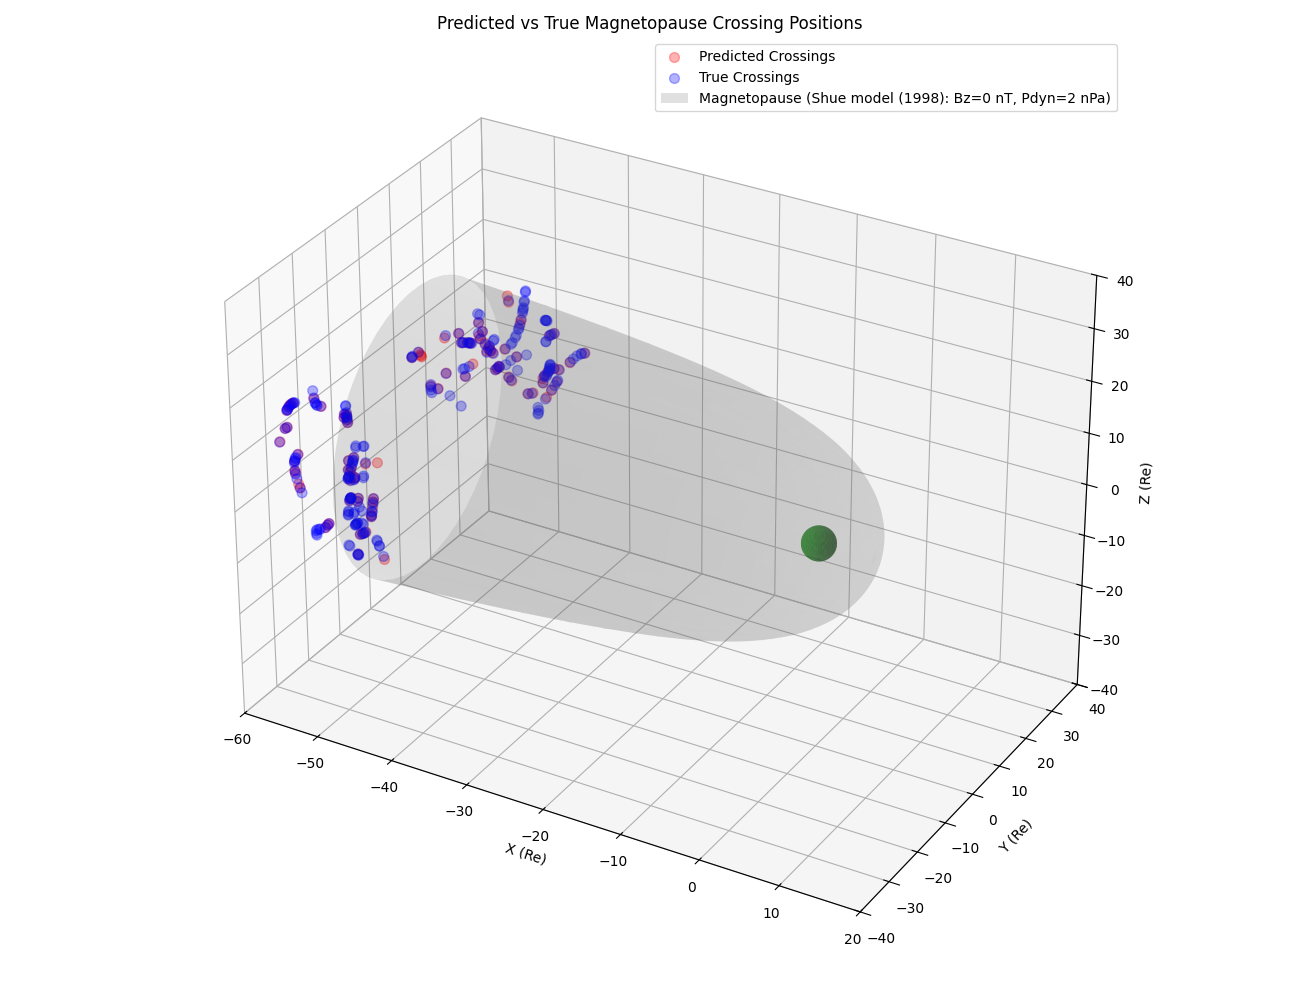

In [183]:
%matplotlib widget
plt.close()
import matplotlib.lines as mlines
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111, projection='3d')

# Create Earth sphere with radius of 1 Re
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)

# Plot predicted positions
ax.scatter(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], 
           c='red', s=50, alpha=0.3, label='Predicted Crossings')

# Plot true positions
ax.scatter(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2], 
           c='blue', s=50, alpha=0.3, label='True Crossings')


# Plot spacecraft trajectory
# ax.plot(true_data_pos[:, 0], true_data_pos[:, 1], true_data_pos[:, 2], 
#         c='black', alpha=0.1, label='Spacecraft Trajectory')

# Set labels
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.set_zlabel('Z (Re)')

# Set equal aspect ratio for all axes
box_aspect = [3/2,1,1]  # Different aspect ratio
ax.set_box_aspect(box_aspect)

# Set axis limits based on data range
xlim = [-60, 20]
ylim = [-40, 40]
zlim = [-40, 40]
ax.set_xlim([-60, 20])
ax.set_ylim([-40, 40])
ax.set_zlim([-40, 40])

# Build the magnetopause surface (using your axis limits)
mp_x, mp_y, mp_z = shue_magnetopause_surface(Bz_nT=0.0, Pdyn_nPa=2.0,
                                             Xmin=-80, Xmax=xlim[1])

# Apply the same visual x-stretch you used for the Earth sphere
x_stretch = (box_aspect[1] / box_aspect[0]) * ((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]))
mp_x_plot = mp_x * x_stretch

# Draw the surface
ax.plot_surface(mp_x_plot, mp_y, mp_z, alpha=0.15, linewidth=0, color='gray', label='Magnetopause (Shue model (1998): Bz=0 nT, Pdyn=2 nPa)')

# Add a legend entry for the surface (plot_surface doesn't auto-legend)
mp_proxy = mlines.Line2D([], [], color='gray', lw=6, alpha=0.6,
                         label='Magnetopause (Shue model: Bz=0 nT, Pdyn=2 nPa)')
handles, labels = ax.get_legend_handles_labels()
handles.append(mp_proxy)
labels.append(mp_proxy.get_label())
ax.legend(handles, labels)

stretch = box_aspect[1]/ box_aspect[0]  # Stretch factor for x-axis

# Earth radius in Re (Earth radii) - 1 Re
earth_radius = 3.0
earth_x = earth_radius * np.outer(np.cos(u), np.sin(v))*stretch*(np.diff(xlim)/np.diff(ylim))
earth_y = earth_radius * np.outer(np.sin(u), np.sin(v))
earth_z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot Earth as a blue sphere
ax.plot_surface(earth_x, earth_y, earth_z, color='green', alpha=0.6)
ax.legend()
ax.set_title('Predicted vs True Magnetopause Crossing Positions')
plt.tight_layout()
plt.show()

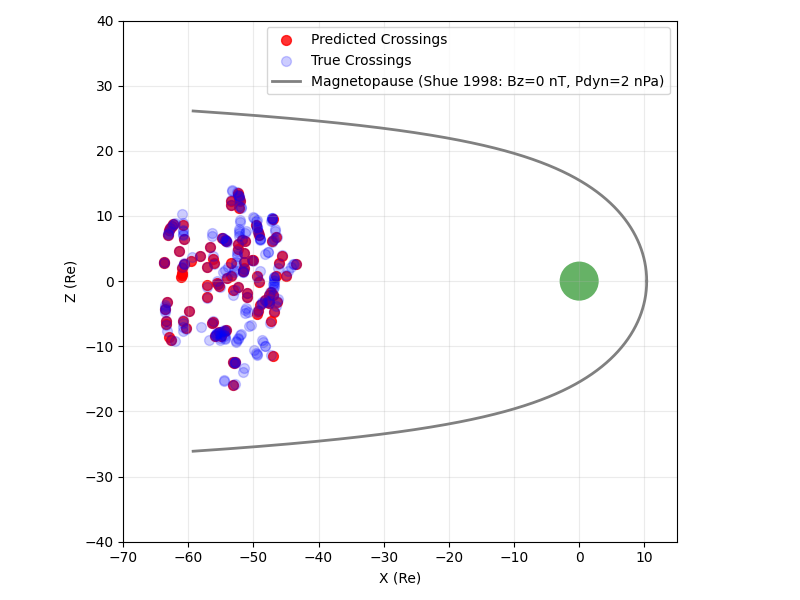

In [186]:
from matplotlib.patches import Circle

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
zlim = [-40, 40]

# (Optional) If you prefer only points near the X–Z plane, filter by |Y|<=delta.
# delta = 2.0
# pred_mask = np.abs(predicted_positions[:, 1]) <= delta
# true_mask = np.abs(true_positions[:, 1]) <= delta
# xp, zp = predicted_positions[pred_mask, 0], predicted_positions[pred_mask, 2]
# xt, zt = true_positions[true_mask, 0], true_positions[true_mask, 2]
# Otherwise, just project by dropping Y:
xp, zp = predicted_positions[:, 0], predicted_positions[:, 2]
xt, zt = true_positions[:, 0], true_positions[:, 2]

# Points (X vs Z)
ax.scatter(xp, zp, c='red', s=50, alpha=0.8, label='Predicted Crossings')
ax.scatter(xt, zt, c='blue', s=50, alpha=0.2, label='True Crossings')

# Magnetopause curve (upper and lower halves)
mp_x, mp_z = shue_magnetopause_xz(Bz_nT=0.0, Pdyn_nPa=2.0)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_z[mask],  lw=2, color='gray',
        label='Magnetopause (Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_z[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='green',
               alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Z (Re)')
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

19-Oct-25 23:00:58: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\shue_model.py:108: RuntimeWarning: divide by zero encountered in divide
  R = r0 * (2.0 / (1.0 + np.cos(theta)))**alpha



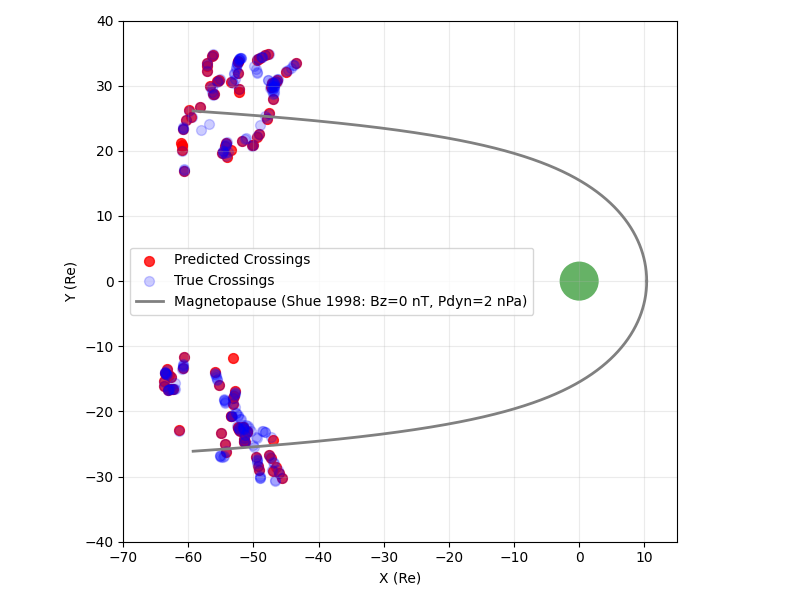

In [185]:
from matplotlib.patches import Circle

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
ylim = [-40, 40]

# (Optional) If you prefer only points near the X–Z plane, filter by |Y|<=delta.
# delta = 2.0
# pred_mask = np.abs(predicted_positions[:, 1]) <= delta
# true_mask = np.abs(true_positions[:, 1]) <= delta
# xp, zp = predicted_positions[pred_mask, 0], predicted_positions[pred_mask, 2]
# xt, zt = true_positions[true_mask, 0], true_positions[true_mask, 2]
# Otherwise, just project by dropping Y:
xp, yp = predicted_positions[:, 0], predicted_positions[:, 1]
xt, yt = true_positions[:, 0], true_positions[:, 1]

# Points (X vs Z)
ax.scatter(xp, yp, c='red', s=50, alpha=0.8, label='Predicted Crossings')
ax.scatter(xt, yt, c='blue', s=50, alpha=0.2, label='True Crossings')

# Magnetopause curve (upper and lower halves)
mp_x, mp_y = shue_magnetopause_xy(Bz_nT=0.0, Pdyn_nPa=2.0)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_y[mask],  lw=2, color='gray',
        label='Magnetopause (Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_y[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='green',
               alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

In [161]:
generation_results_B = model.get_results(generation_samples_B, crossing_times=None, window_average_errors=3)
generation_results_C = model.get_results(generation_samples_C, crossing_times=None, window_average_errors=3)

In [162]:
# Get predicted crossing times
predicted_crossing_times_norm_B = np.sort(np.array(generation_results_B['zero_crossing_times_normalized']))
predicted_crossing_times_norm_C = np.sort(np.array(generation_results_C['zero_crossing_times_normalized']))

In [ ]:
# file = 'crossings/predicted_crossing_times_mag_mask_avg3_v3.npz'

# # Save the datetime arrays to a file
# np.savez(file, 
#          times_B=predicted_crossing_times_norm_B,
#          times_C=predicted_crossing_times_norm_C)


In [8]:
file = 'crossings/predicted_crossing_times_mag_mask_avg3_v3.npz'
# Load the data back from the file
loaded_data = np.load(file)
predicted_crossing_times_norm_B = loaded_data['times_B']
predicted_crossing_times_norm_C = loaded_data['times_C']

print(f"Loaded {len(predicted_crossing_times_norm_B)} crossing times for spacecraft B")
print(f"Loaded {len(predicted_crossing_times_norm_C)} crossing times for spacecraft C")

Loaded 1759 crossing times for spacecraft B
Loaded 1753 crossing times for spacecraft C


In [9]:
end_time =  str(predicted_crossing_times_norm_B[-1])
start_time =  str(predicted_crossing_times_norm_B[0])
cdaweb_obj = pyspedas.CDAWeb()

print(f"Start time: {start_time}, End time: {end_time}")
dataset = 'THB_OR_SSC (2007-02-24 to 2025-08-31)'

# Get the list of files for the specified time range
urllist = cdaweb_obj.get_filenames([dataset],start_time, end_time)
cdaweb_obj.cda_download(urllist,"cdaweb/", varnames=['XYZ_GSE'])

true_data_B = get_data('XYZ_GSE')

true_data_times_B = true_data_B.times 
true_data_pos_B = true_data_B.y

Start time: 2013-08-17T16:11:23.942388476, End time: 2025-07-12T06:12:03.364016452


28-Oct-25 14:56:14: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20130801_v01.cdf
28-Oct-25 14:56:15: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20130901_v01.cdf
28-Oct-25 14:56:15: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20131001_v01.cdf
28-Oct-25 14:56:16: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20131101_v01.cdf
28-Oct-25 14:56:17: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2013\thb_or_ssc_20131201_v01.cdf
28-Oct-25 14:56:17: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\ssc\2014\thb_or_ssc_20140101_v01.cdf
28-Oct-25 14:56:18: File is curren

In [10]:
end_time =  str(predicted_crossing_times_norm_C[-1])
start_time =  str(predicted_crossing_times_norm_C[0])

print(f"Start time: {start_time}, End time: {end_time}")
dataset = 'THC_OR_SSC (2007-02-24 to 2025-08-31)'

# Get the list of files for the specified time range
urllist = cdaweb_obj.get_filenames([dataset],start_time, end_time)
cdaweb_obj.cda_download(urllist, "cdaweb/", varnames=['XYZ_GSE'])

true_data_C = get_data('XYZ_GSE')

true_data_times_C = true_data_C.times 
true_data_pos_C = true_data_C.y


Start time: 2013-08-18T07:41:22.335877986, End time: 2025-07-12T16:27:08.990614850


28-Oct-25 15:04:14: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20130801_v01.cdf
28-Oct-25 15:04:14: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20130901_v01.cdf
28-Oct-25 15:04:15: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20131001_v01.cdf
28-Oct-25 15:04:16: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20131101_v01.cdf
28-Oct-25 15:04:16: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2013\thc_or_ssc_20131201_v01.cdf
28-Oct-25 15:04:17: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thc\ssc\2014\thc_or_ssc_20140101_v01.cdf
28-Oct-25 15:04:18: File is curren

In [18]:
### EXTRACT PREDICTED CROSSING POSITIONS FROM CDAWEB FOR GENERATION DATASET B ###

# Convert datetime64 arrays to numeric values for interpolation
data_times_numeric_B = (true_data_times_B * 1e9).astype('datetime64[ns]').astype(np.int64)
predicted_times_numeric_B = predicted_crossing_times_norm_B.astype('datetime64[ns]').astype(np.int64)

# Interpolate positions for predicted crossing times
predicted_positions_B = np.zeros((len(predicted_crossing_times_norm_B), true_data_pos_B.shape[1]))

for i in range(true_data_pos_B.shape[1]):
    predicted_positions_B[:, i] = np.interp(predicted_times_numeric_B, data_times_numeric_B, true_data_pos_B[:, i])



In [19]:
### EXTRACT PREDICTED CROSSING POSITIONS FROM CDAWEB FOR GENERATION DATASET C ###

# Convert datetime64 arrays to numeric values for interpolation
data_times_numeric_C = (true_data_times_C * 1e9).astype('datetime64[ns]').astype(np.int64)
predicted_times_numeric_C = predicted_crossing_times_norm_C.astype('datetime64[ns]').astype(np.int64)

# Interpolate positions for predicted crossing times
predicted_positions_C = np.zeros((len(predicted_crossing_times_norm_C), true_data_pos_C.shape[1]))

for i in range(true_data_pos_C.shape[1]):
    predicted_positions_C[:, i] = np.interp(predicted_times_numeric_C, data_times_numeric_C, true_data_pos_C[:, i])



In [ ]:
# predicted_positions_C = predicted_positions_C_og
# predicted_positions_B = predicted_positions_B_og

In [ ]:
# predicted_positions_B_og = predicted_positions_B.copy()
# predicted_positions_C_og = predicted_positions_C.copy()

In [39]:
from tqdm import tqdm
from Helper.cotrans import GSE_to_aSWGSM_array, group_crossings_by_month, get_solar_wind_pressure

# Get dipole tilt angle of all data points for B
predicted_positions_B_aGSM, aberration_y_array_B, aberration_z_array_B = GSE_to_aSWGSM_array(predicted_positions_B, predicted_crossing_times_norm_B)

# Get dipole tilt angle of all data points for C
predicted_positions_C_aGSM, aberration_y_array_C, aberration_z_array_C  = GSE_to_aSWGSM_array(predicted_positions_C, predicted_crossing_times_norm_C)


20-Oct-25 10:11:13: ['geo', 'gei', 'gse']
20-Oct-25 10:11:13: Running transformation: subgeo2gei
20-Oct-25 10:11:13: Running transformation: subgei2gse
20-Oct-25 10:11:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
20-Oct-25 10:11:14: File is current: omni_data/hro_5min/2013/omni_hro_5min_20130801_v01.cdf
20-Oct-25 10:11:14: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
20-Oct-25 10:11:15: File is current: omni_data/hro_5min/2013/omni_hro_5min_20130901_v01.cdf
20-Oct-25 10:11:16: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
20-Oct-25 10:11:16: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131001_v01.cdf
20-Oct-25 10:11:17: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
20-Oct-25 10:11:17: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131101_v01.cdf
20-Oct-25 10:11:18: Down

In [28]:
# Combine predicted positions from both spacecraft
indices = np.argsort(np.concatenate([predicted_crossing_times_norm_B, predicted_crossing_times_norm_C]))
predicted_times_combined = np.concatenate([predicted_crossing_times_norm_B, predicted_crossing_times_norm_C])[indices]
predicted_positions_aGSM_combined = np.vstack([predicted_positions_B_aGSM, predicted_positions_C_aGSM])[indices]

# Get grouped crossings by month
from Helper.cotrans import get_solar_wind_pressure_array
pressures = get_solar_wind_pressure_array(predicted_times_combined)


28-Oct-25 15:42:42: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
28-Oct-25 15:42:43: File is current: omni_data/hro_5min/2013/omni_hro_5min_20130801_v01.cdf
28-Oct-25 15:42:43: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
28-Oct-25 15:42:44: File is current: omni_data/hro_5min/2013/omni_hro_5min_20130901_v01.cdf
28-Oct-25 15:42:44: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
28-Oct-25 15:42:44: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131001_v01.cdf
28-Oct-25 15:42:45: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
28-Oct-25 15:42:45: File is current: omni_data/hro_5min/2013/omni_hro_5min_20131101_v01.cdf
28-Oct-25 15:42:45: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
28-Oct-25 15:42:46: File is current: omni_data/hro_5min/2013/o

Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint
Debug breakpoint


28-Oct-25 15:43:26: File is current: omni_data/hro_5min/2017/omni_hro_5min_20171001_v01.cdf
28-Oct-25 15:43:27: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2017/
28-Oct-25 15:43:27: File is current: omni_data/hro_5min/2017/omni_hro_5min_20171101_v01.cdf
28-Oct-25 15:43:27: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2017/
28-Oct-25 15:43:28: File is current: omni_data/hro_5min/2017/omni_hro_5min_20171201_v01.cdf
28-Oct-25 15:43:28: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2018/
28-Oct-25 15:43:29: File is current: omni_data/hro_5min/2018/omni_hro_5min_20180101_v01.cdf
28-Oct-25 15:43:29: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2018/
28-Oct-25 15:43:30: File is current: omni_data/hro_5min/2018/omni_hro_5min_20180201_v01.cdf
28-Oct-25 15:43:30: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/om

In [16]:

file = 'crossings_aGSM/predicted_crossing_times_mag_mask_avg3_v2.npz'

# # Save the datetime arrays to a file
# np.savez(file, 
#          times_B=predicted_crossing_times_norm_B,
#          times_C=predicted_crossing_times_norm_C,
#          pos_B=predicted_positions_B_aGSM,
#          pos_C=predicted_positions_C_aGSM,
#          aberration_z_B=aberration_z_array_B,
#          aberration_y_B=aberration_y_array_B,
#          aberration_z_C=aberration_z_array_C,
#          aberration_y_C=aberration_y_array_C)



In [17]:
# Load the data back from the file
loaded_data = np.load(file)
predicted_crossing_times_norm_B = loaded_data['times_B']
predicted_crossing_times_norm_C = loaded_data['times_C']
predicted_positions_B_aGSM = loaded_data['pos_B']
predicted_positions_C_aGSM = loaded_data['pos_C']
aberration_y_array_C = loaded_data['aberration_y_C']
aberration_z_array_C = loaded_data['aberration_z_C']
aberration_y_array_B = loaded_data['aberration_y_B']
aberration_z_array_B = loaded_data['aberration_z_B']



print(f"Loaded {len(predicted_crossing_times_norm_B)} crossing times for spacecraft B")
print(f"Loaded {len(predicted_crossing_times_norm_C)} crossing times for spacecraft C")

Loaded 1476 crossing times for spacecraft B
Loaded 1596 crossing times for spacecraft C


In [20]:
### REMOVE CROSSINGS IN LUNAR WAKE ###  
times_crossing_B = [str(time.astype('datetime64[s]')) for time in predicted_crossing_times_norm_B]
crossings_in_wake_B = lunar_wake_check_series(predicted_positions_B, times_crossing_B, aberration_y_array_B, aberration_z_array_B)

# Removal
predicted_crossing_times_norm_B = predicted_crossing_times_norm_B[~np.array(crossings_in_wake_B)]
predicted_positions_B_aGSM = predicted_positions_B_aGSM[~np.array(crossings_in_wake_B)]

### REMOVE CROSSINGS IN LUNAR WAKE ###  
times_crossing_C = [str(time.astype('datetime64[s]')) for time in predicted_crossing_times_norm_C]
crossings_in_wake_C = lunar_wake_check_series(predicted_positions_C, times_crossing_C, aberration_y_array_C, aberration_z_array_C)

# Removal
predicted_crossing_times_norm_C = predicted_crossing_times_norm_C[~np.array(crossings_in_wake_C)]
predicted_positions_C_aGSM = predicted_positions_C_aGSM[~np.array(crossings_in_wake_C)]

In [ ]:
# # Filter B spacecraft data
# mask_B = np.ones(len(predicted_crossing_times_norm_B), dtype=bool)
# crossing_times_B = predicted_crossing_times_norm_B.astype('datetime64[ns]')

# # Filter C spacecraft data
# mask_C = np.ones(len(predicted_crossing_times_norm_C), dtype=bool)
# crossing_times_C = predicted_crossing_times_norm_C.astype('datetime64[ns]')

# for i in range(len(crossing_times_C)):
#     # Remove crossings with x > 40
#     if predicted_positions_C[i, 0] > -40:
#         mask_C[i] = False
#         continue


# for i in range(len(crossing_times_B)):
#     # Remove crossings with x > 40
#     if predicted_positions_B[i, 0] > -40:
#         mask_B[i] = False
#         continue


# # Apply the masks to filter the data
# predicted_crossing_times_norm_B = predicted_crossing_times_norm_B[mask_B]
# predicted_positions_B = predicted_positions_B[mask_B]
# predicted_positions_B_og = predicted_positions_B_og[mask_B]

# predicted_crossing_times_norm_C = predicted_crossing_times_norm_C[mask_C]
# predicted_positions_C = predicted_positions_C[mask_C]
# predicted_positions_C_og = predicted_positions_C_og[mask_C]


In [21]:
# Create a mask to filter out crossings from the 2017 september solar flare 
mask_C_event = ~((predicted_crossing_times_norm_C >= np.datetime64('2017-09-07T00:00:00.000000000', 'ns')) & (predicted_crossing_times_norm_C <= np.datetime64('2017-09-20T00:00:00.000000000', 'ns')))
mask_B_event = ~((predicted_crossing_times_norm_B >= np.datetime64('2017-09-07T00:00:00.000000000', 'ns')) & (predicted_crossing_times_norm_B <= np.datetime64('2017-09-20T00:00:00.000000000', 'ns')))
mask_C_event &= ~((predicted_crossing_times_norm_C >= np.datetime64('2022-07-16T00:00:00.000000000', 'ns')) & (predicted_crossing_times_norm_C <= np.datetime64('2022-07-18T00:00:00.000000000', 'ns')))
mask_B_event &= ~((predicted_crossing_times_norm_B >= np.datetime64('2022-07-16T00:00:00.000000000', 'ns')) & (predicted_crossing_times_norm_B <= np.datetime64('2022-07-18T00:00:00.000000000', 'ns')))
# mask_C_event &= ~((predicted_crossing_times_norm_C >= np.datetime64('2022-04-15T00:00:00.000000000', 'ns')) & (predicted_crossing_times_norm_C <= np.datetime64('2022-04-15T10:00:00.000000000', 'ns')))
# mask_B_event &= ~((predicted_crossing_times_norm_B >= np.datetime64('2022-04-15T00:00:00.000000000', 'ns')) & (predicted_crossing_times_norm_B <= np.datetime64('2022-04-15T10:00:00.000000000', 'ns')))


predicted_crossing_times_norm_C_no_events = predicted_crossing_times_norm_C[mask_C_event]
predicted_positions_C_no_events = predicted_positions_C_aGSM[mask_C_event]

predicted_crossing_times_norm_B_no_events = predicted_crossing_times_norm_B[mask_B_event]
predicted_positions_B_no_events = predicted_positions_B_aGSM[mask_B_event]

def filter_outliers(predicted_positions_B, predicted_positions_C, predicted_crossing_times_norm_B, predicted_crossing_times_norm_C, mean=None, std=None):
    """
    Filter outliers based on distance from X-axis using 2-sigma threshold.
    
    Parameters:
    predicted_positions_B: array of positions for spacecraft B
    predicted_positions_C: array of positions for spacecraft C
    predicted_crossing_times_norm_B: array of crossing times for spacecraft B
    predicted_crossing_times_norm_C: array of crossing times for spacecraft C
    
    Returns:
    dict with keys:
    - 'inward_outliers': combined inward outlier times
    - 'outward_outliers': combined outward outlier times
    - 'positions_B_no_outliers': filtered positions B
    - 'positions_C_no_outliers': filtered positions C
    """
    # Calculate distance from X-axis of all crossings
    Re_distance_B = np.sqrt(predicted_positions_B[:, 1]**2 + predicted_positions_B[:, 2]**2)
    Re_distance_C = np.sqrt(predicted_positions_C[:, 1]**2 + predicted_positions_C[:, 2]**2)

    # Calculate outward and inward outliers based on Re distance from X axis by taking mean and standard deviation
    Re_mean_B = Re_distance_B.mean()
    Re_std_B = Re_distance_B.std()
    Re_mean_C = Re_distance_C.mean()
    Re_std_C = Re_distance_C.std()

    # Total length
    cross_total = len(predicted_positions_B) + len(predicted_positions_C)
    cross_B = len(predicted_positions_B)
    cross_C = len(predicted_positions_C)

    # Team mean and std
    Re_mean = (Re_mean_B * (cross_B/cross_total) + Re_mean_C * (cross_C/cross_total))
    Re_std = (Re_std_B * (cross_B/cross_total) + Re_std_C * (cross_C/cross_total))

    if mean != None and std != None:
        Re_mean = mean
        Re_std = std

    # Threshold 
    Re_threshold_positive = Re_mean + 2 * Re_std
    Re_threshold_negative = Re_mean - 2 * Re_std

    print(f'Earth radii threshold positive: {Re_threshold_positive:.3f}')
    print(f'Earth radii threshold negative: {Re_threshold_negative:.3f}')
    print(f'Earth radii mean: {Re_mean}')
    print(f'Earth radii std: {Re_std}')

    # Identify outliers for both spacecraft
    outward_outliers_B_mask = Re_distance_B > Re_threshold_positive
    outward_outliers_C_mask = Re_distance_C > Re_threshold_positive
    inward_outliers_B_mask = Re_distance_B < Re_threshold_negative
    inward_outliers_C_mask = Re_distance_C < Re_threshold_negative

    # Get outlier times and positions
    outward_outliers_B = predicted_crossing_times_norm_B[outward_outliers_B_mask]
    outward_outliers_C = predicted_crossing_times_norm_C[outward_outliers_C_mask]
    outward_outliers_B_pos = predicted_positions_B[outward_outliers_B_mask]
    outward_outliers_C_pos = predicted_positions_C[outward_outliers_C_mask]

    inward_outliers_B = predicted_crossing_times_norm_B[inward_outliers_B_mask]
    inward_outliers_C = predicted_crossing_times_norm_C[inward_outliers_C_mask]
    inward_outliers_B_pos = predicted_positions_B[inward_outliers_B_mask]
    inward_outliers_C_pos = predicted_positions_C[inward_outliers_C_mask]

    # Combine and sort outlier times
    outward_outliers = np.sort(np.concatenate((outward_outliers_B, outward_outliers_C)))
    inward_outliers = np.sort(np.concatenate((inward_outliers_B, inward_outliers_C)))

    # Get sorting indices for positions to match the sorted times
    outward_combined_times = np.concatenate((outward_outliers_B, outward_outliers_C))
    outward_sort_indices = np.argsort(outward_combined_times)
    outward_outliers_pos = np.concatenate((outward_outliers_B_pos, outward_outliers_C_pos))[outward_sort_indices]

    inward_combined_times = np.concatenate((inward_outliers_B, inward_outliers_C))
    inward_sort_indices = np.argsort(inward_combined_times)
    inward_outliers_pos = np.concatenate((inward_outliers_B_pos, inward_outliers_C_pos))[inward_sort_indices]

    # Mask for outliers
    outlier_mask_B = (Re_distance_B > Re_threshold_positive) | (Re_distance_B < Re_threshold_negative)
    outlier_mask_C = (Re_distance_C > Re_threshold_positive) | (Re_distance_C < Re_threshold_negative)

    predicted_positions_B_no_outliers = predicted_positions_B[~outlier_mask_B]
    predicted_positions_C_no_outliers = predicted_positions_C[~outlier_mask_C]

    predicted_crossing_times_norm_B_no_outliers = predicted_crossing_times_norm_B[~outlier_mask_B]
    predicted_crossing_times_norm_C_no_outliers = predicted_crossing_times_norm_C[~outlier_mask_C]
    return {
        'inward_outliers': inward_outliers,
        'inward_outliers_pos': inward_outliers_pos,
        'outward_outliers': outward_outliers,
        'outward_outliers_pos': outward_outliers_pos,
        'positions_B_no_outliers': predicted_positions_B_no_outliers,
        'positions_C_no_outliers': predicted_positions_C_no_outliers,
        'times_B_no_outliers': predicted_crossing_times_norm_B_no_outliers,
        'times_C_no_outliers': predicted_crossing_times_norm_C_no_outliers,
        'mean': Re_mean,
        'std': Re_std
    }

# Call the function
outlier_results = filter_outliers(predicted_positions_B_aGSM, predicted_positions_C_aGSM, 
                                predicted_crossing_times_norm_B, predicted_crossing_times_norm_C)

# Extract results
inward_outliers = outlier_results['inward_outliers']
inward_outliers_pos = outlier_results['inward_outliers_pos']
outward_outliers = outlier_results['outward_outliers']
outward_outliers_pos = outlier_results['outward_outliers_pos']
predicted_positions_B_no_outliers = outlier_results['positions_B_no_outliers']
predicted_positions_C_no_outliers = outlier_results['positions_C_no_outliers']
predicted_crossing_times_norm_B_no_outliers = outlier_results['times_B_no_outliers']
predicted_crossing_times_norm_C_no_outliers = outlier_results['times_C_no_outliers']

Re_mean = outlier_results['mean']
Re_std = outlier_results['std']

# Call function on no events arrays
outlier_results_no_events = filter_outliers(predicted_positions_B_no_events, predicted_positions_C_no_events, 
                                predicted_crossing_times_norm_B_no_events, predicted_crossing_times_norm_C_no_events,
                                mean=Re_mean, std=Re_std)

# Extract results
inward_outliers_no_events = outlier_results_no_events['inward_outliers']
outward_outliers_no_events = outlier_results_no_events['outward_outliers']
predicted_positions_B_no_outliers_no_events = outlier_results_no_events['positions_B_no_outliers']
predicted_positions_C_no_outliers_no_events = outlier_results_no_events['positions_C_no_outliers']

Earth radii threshold positive: 33.126
Earth radii threshold negative: 17.334
Earth radii mean: 25.230079026563914
Earth radii std: 3.948061274123938
Earth radii threshold positive: 33.126
Earth radii threshold negative: 17.334
Earth radii mean: 25.230079026563914
Earth radii std: 3.948061274123938


28-Oct-25 15:36:56: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(



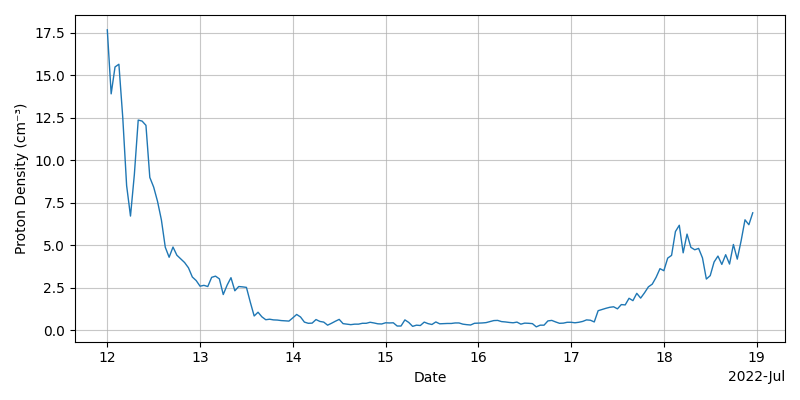

In [24]:
import pandas as pd

# Get hourly proton density
data_density = []
with open("omni_wind_proton_density.txt", "r") as f:
    for line in f:
        parts = line.split()  # or .split('\t') if tab-separated
        for i in range(len(parts)):
            parts[i] = float(parts[i])

        parts = np.array(parts)
        data_density.append(parts)

data_density = np.vstack(data_density)

# Convert to DataFrame for easier processing
density_df = pd.DataFrame(data_density, columns=['year', 'doy', 'hr', 'unused', 'density'])
# Convert year and day of year to datetime
density_df['date'] = pd.to_datetime(density_df['year'].astype(int).astype(str) + 
                                   density_df['doy'].astype(int).astype(str) + 
                                   density_df['hr'].astype(int).astype(str), 
                                   format='%Y%j%H')

# Create a simple plot of density vs date
plt.figure(figsize=(8,4))
plt.plot(density_df['date'], density_df['density'], linewidth=1, alpha=1)
plt.xlabel('Date')
plt.ylabel('Proton Density (cm⁻³)')
plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# Get daily sunspot number
data = []
with open("omni2_daily_sunspot_number.txt", "r") as f:
    for line in f:
        parts = line.split()  # or .split('\t') if tab-separated
        for i in range(len(parts)):
            parts[i] = int(parts[i])
        parts = np.array(parts)
        data.append(parts)

data = np.vstack(data)

# Convert to DataFrame for easier processing
sunspot_df = pd.DataFrame(data, columns=['year', 'doy', 'unused', 'sunspot_number'])

# Convert year and day of year to datetime
sunspot_df['date'] = pd.to_datetime(sunspot_df['year'].astype(str) + sunspot_df['doy'].astype(str), format='%Y%j')

# Extract year and month
sunspot_df['month'] = sunspot_df['date'].dt.month

# Calculate monthly averages
monthly_sunspot = sunspot_df.groupby(['year', 'month'])['sunspot_number'].mean().reset_index()
monthly_sunspot['year_month'] = monthly_sunspot['year'].astype(str) + '-' + monthly_sunspot['month'].astype(str).str.zfill(2)

# print("Monthly sunspot averages:")
# print(monthly_sunspot.head(10))

daily_sunspot = sunspot_df.groupby(['year', 'doy'])['sunspot_number'].mean().reset_index()
daily_sunspot['year_day'] = daily_sunspot['year'].astype(str) + '-' + daily_sunspot['doy'].astype(str).str.zfill(2)
# print(daily_sunspot.head(10))

In [46]:
np.sum(np.isnan(pressures))

0

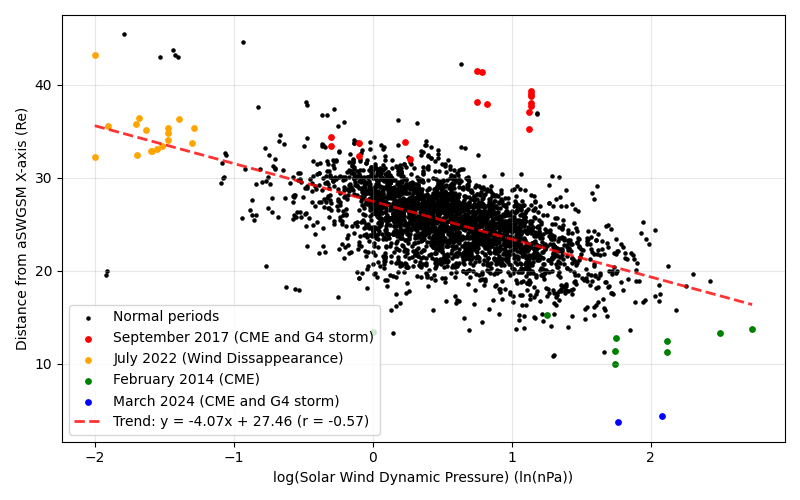

Correlation coefficient: -0.566
Trendline equation: y = -4.068x + 27.457


array(['2020-12-04T02:45:07.020556328', '2020-12-04T03:38:25.894695749',
       '2020-12-04T05:30:23.004564245', '2022-07-16T23:20:46.110079258',
       '2025-03-18T22:34:16.701909329', '2025-03-18T22:46:34.697212080',
       '2025-03-19T03:50:29.979661735'], dtype='datetime64[ns]')

In [37]:
Radii_B = np.sqrt(predicted_positions_B_aGSM[:, 1]**2 + predicted_positions_B_aGSM[:, 2]**2)
Radii_C = np.sqrt(predicted_positions_C_aGSM[:, 1]**2 + predicted_positions_C_aGSM[:, 2]**2)

Radii_combined = np.concatenate([Radii_B, Radii_C])[indices]

# Define separate event masks
event_2017 = ((predicted_times_combined >= np.datetime64('2017-09-08T20:00:00.000000000', 'ns')) & (predicted_times_combined <= np.datetime64('2017-09-20T00:00:00.000000000', 'ns')))
event_2022 = ((predicted_times_combined >= np.datetime64('2022-07-15T16:00:00.000000000', 'ns')) & (predicted_times_combined <= np.datetime64('2022-07-18T00:00:00.000000000', 'ns')))
event_2014 = ((predicted_times_combined >= np.datetime64('2014-02-15T00:00:00.000000000', 'ns')) & (predicted_times_combined <= np.datetime64('2014-02-15T23:00:00.000000000', 'ns')))
event_2024 = ((predicted_times_combined >= np.datetime64('2024-03-25T00:00:00.000000000', 'ns')) & (predicted_times_combined <= np.datetime64('2024-03-25T12:00:00.000000000', 'ns')))
# Combined event mask
event_all = event_2017 | event_2022 | event_2014 | event_2024

# Take logarithm of pressures
log_pressures = np.log(pressures)

# Calculate trendline using linear regression on all data
z = np.polyfit(log_pressures, Radii_combined, 1)
p = np.poly1d(z)

# Plot log(pressures) vs Radii
plt.figure(figsize=(8,5))
plt.scatter(log_pressures[~event_all], Radii_combined[~event_all], alpha=1, s=5, label='Normal periods', color='black')
plt.scatter(log_pressures[event_2017], Radii_combined[event_2017], alpha=1, s=15, color='red', label='September 2017 (CME and G4 storm)')
plt.scatter(log_pressures[event_2022], Radii_combined[event_2022], alpha=1, s=15, color='orange', label='July 2022 (Wind Dissappearance)')
plt.scatter(log_pressures[event_2014], Radii_combined[event_2014], alpha=1, s=15, color='green', label='February 2014 (CME)')
plt.scatter(log_pressures[event_2024], Radii_combined[event_2024], alpha=1, s=15, color='blue', label='March 2024 (CME and G4 storm)')

# Add trendline
x_trend = np.linspace(log_pressures.min(), log_pressures.max(), 100)
plt.plot(x_trend, p(x_trend), 'r--', alpha=0.8, linewidth=2,
         label=f'Trend: y = {z[0]:.2f}x + {z[1]:.2f} (r = {correlation:.2f})')

plt.xlabel('log(Solar Wind Dynamic Pressure) (ln(nPa))')
plt.ylabel('Distance from aSWGSM X-axis (Re)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

correlation = np.corrcoef(log_pressures, Radii_combined)[0, 1]
print(f"Correlation coefficient: {correlation:.3f}")
print(f"Trendline equation: y = {z[0]:.3f}x + {z[1]:.3f}")
predicted_times_combined[(Radii_combined>40) & (log_pressures<-0.8)]


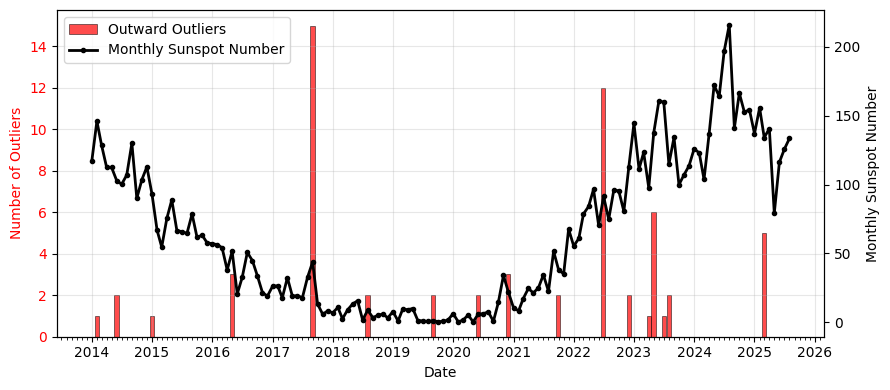

Total outward outliers: 71
Date range: 2013-08-17 16:11:23.942388476 to 2025-03-19 03:50:29.979661735


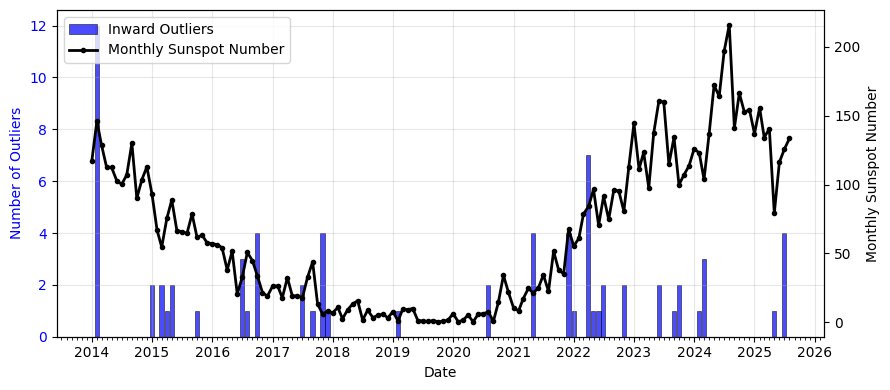

Total inward outliers: 76
Date range: 2013-11-16 07:25:40.618279025 to 2025-07-11 17:57:02.263498165


In [49]:
# Create histogram of outward outliers by month with sunspot overlay
import matplotlib.pyplot as plt
%matplotlib inline

# Convert to pandas datetime for easier manipulation
outlier_df = pd.DataFrame({
    'datetime': pd.to_datetime(outward_outliers)
})

# Set date range and bin configuration
start_date = '2014-01'
end_date = '2025-08'
bin_frequency = 'ME'  # 'M' for monthly, 'Q' for quarterly, 'Y' for yearly

# Create date range for bins
date_range = pd.date_range(start=start_date, end=end_date, freq=bin_frequency)

# Count outliers per bin
outlier_counts, bin_edges = np.histogram(outlier_df['datetime'], bins=date_range)

# Prepare sunspot data for overlay
monthly_sunspot['datetime'] = pd.to_datetime(monthly_sunspot['year'].astype(str) + '-' + monthly_sunspot['month'].astype(str).str.zfill(2))
sunspot_filtered = monthly_sunspot[(monthly_sunspot['datetime'] >= pd.to_datetime(start_date)) & 
                                  (monthly_sunspot['datetime'] <= pd.to_datetime(end_date))]

# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot histogram on primary y-axis
bars = ax1.bar(date_range[:-1], outlier_counts, width=25, alpha=0.7, color='red', 
               edgecolor='black', linewidth=0.5, label='Outward Outliers')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Outliers', color='red')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary y-axis for sunspot data
ax2 = ax1.twinx()
line = ax2.plot(sunspot_filtered['datetime'], sunspot_filtered['sunspot_number'], 
                color='black', linewidth=2, marker='o', markersize=3, 
                label='Monthly Sunspot Number')

ax2.set_ylabel('Monthly Sunspot Number', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Format x-axis dates
import matplotlib.dates as mdates
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Total outward outliers: {len(outward_outliers)}")
print(f"Date range: {outlier_df['datetime'].min()} to {outlier_df['datetime'].max()}")

# Create histogram of inward outliers by month with sunspot overlay
inward_outlier_df = pd.DataFrame({
    'datetime': pd.to_datetime(inward_outliers)
})

# Count inward outliers per bin
inward_counts, bin_edges = np.histogram(inward_outlier_df['datetime'], bins=date_range)

# Create the plot for inward outliers with dual y-axes
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot histogram on primary y-axis
bars = ax1.bar(date_range[:-1], inward_counts, width=25, alpha=0.7, color='blue', 
               edgecolor='black', linewidth=0.5, label='Inward Outliers')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Outliers', color='blue')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for sunspot data
ax2 = ax1.twinx()
line = ax2.plot(sunspot_filtered['datetime'], sunspot_filtered['sunspot_number'], 
                color='black', linewidth=2, marker='o', markersize=3, 
                label='Monthly Sunspot Number')

ax2.set_ylabel('Monthly Sunspot Number', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Format x-axis dates
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Total inward outliers: {len(inward_outliers_no_events)}")
print(f"Date range: {inward_outlier_df['datetime'].min()} to {inward_outlier_df['datetime'].max()}")

In [343]:
outward_outliers

array(['2013-08-17T16:11:23.942388476', '2013-08-17T16:46:33.399057113',
       '2013-08-18T07:41:22.335877986', '2013-08-18T08:03:43.175627121',
       '2013-11-14T05:05:02.946646694', '2013-12-19T19:36:05.814948091',
       '2013-12-19T19:55:57.499490830', '2013-12-19T19:58:03.103645787',
       '2013-12-19T20:11:42.056615169', '2014-02-17T14:43:18.356931195',
       '2014-06-09T21:37:21.158108624', '2014-06-09T22:19:05.194437626',
       '2015-01-01T02:49:42.576872959', '2016-05-24T04:19:08.337430082',
       '2016-05-24T05:36:26.783840291', '2016-05-24T05:50:45.486587883',
       '2017-09-08T20:25:51.735497513', '2017-09-08T21:00:18.953893326',
       '2017-09-08T21:56:59.880448592', '2017-09-08T21:59:04.551156756',
       '2017-09-09T03:38:10.262941728', '2017-09-09T03:52:44.680630439',
       '2017-09-09T06:08:23.770177042', '2017-09-09T06:30:07.104735178',
       '2017-09-09T06:39:35.472338526', '2017-09-09T07:09:59.827667742',
       '2017-09-09T07:11:47.856125298', '2017-09-09

In [ ]:
# # Create mask to filter out predicted crossings based on the criteria for each spacecraft

# # Filter B spacecraft data
# mask_B = np.ones(len(predicted_crossing_times_norm_B), dtype=bool)
# crossing_times_B = predicted_crossing_times_norm_B.astype('datetime64[ns]')

# for i in range(len(crossing_times_B) - 1):
#     # Check if two crossings are within 90 minutes of each other
#     time_diff = (crossing_times_B[i+1] - crossing_times_B[i]) / np.timedelta64(1, 'm')
    
#     if time_diff <= 90:
#         # Check if Y positions are beyond ±30 Re OR within ±20 Re
#         y1, y2 = predicted_positions_B[i, 1], predicted_positions_B[i+1, 1]
        
#         if ((y1 < -30 or y1 > 30) and (y2 < -30 or y2 > 30)):
#             # Check 3-hour window (2 hours before first, 2 hours after second)
#             window_start = crossing_times_B[i] - np.timedelta64(90, 'm')
#             window_end = crossing_times_B[i+1] + np.timedelta64(90, 'm')
            
#             # Find other crossings in this window (excluding the pair itself)
#             window_mask = (crossing_times_B >= window_start) & (crossing_times_B <= window_end)
#             window_indices = np.where(window_mask)[0]
#             other_crossings = [idx for idx in window_indices if idx != i and idx != i+1]
            
#             # If no other crossings in the 4-hour window, mark for removal
#             if len(other_crossings) == 0:
#                 mask_B[i] = False
#                 mask_B[i+1] = False

# # Filter C spacecraft data
# mask_C = np.ones(len(predicted_crossing_times_norm_C), dtype=bool)
# crossing_times_C = predicted_crossing_times_norm_C.astype('datetime64[ns]')

# for i in range(len(crossing_times_C) - 1):

#     # Check if two crossings are within 90 minutes of each other
#     time_diff = (crossing_times_C[i+1] - crossing_times_C[i]) / np.timedelta64(1, 'm')
    
#     if time_diff <= 90:
#         # Check if Y positions are beyond ±30 Re OR within ±20 Re
#         y1, y2 = predicted_positions_C[i, 1], predicted_positions_C[i+1, 1]
        
#         if ((y1 < -30 or y1 > 30) and (y2 < -30 or y2 > 30)):
#             # Check 3-hour window (2 hours before first, 2 hours after second)
#             window_start = crossing_times_C[i] - np.timedelta64(90, 'm')
#             window_end = crossing_times_C[i+1] + np.timedelta64(90, 'm')
            
#             # Find other crossings in this window (excluding the pair itself)
#             window_mask = (crossing_times_C >= window_start) & (crossing_times_C <= window_end)
#             window_indices = np.where(window_mask)[0]
#             other_crossings = [idx for idx in window_indices if idx != i and idx != i+1]
            
#             # If no other crossings in the 4-hour window, mark for removal
#             if len(other_crossings) == 0:
#                 mask_C[i] = False
#                 mask_C[i+1] = False



# # Apply the masks to filter the data
# predicted_crossing_times_norm_B = predicted_crossing_times_norm_B[mask_B]
# predicted_positions_B = predicted_positions_B[mask_B]

# predicted_crossing_times_norm_C = predicted_crossing_times_norm_C[mask_C]
# predicted_positions_C = predicted_positions_C[mask_C]

# print(f"Removed crossings for B: {np.sum(~mask_B)}")
# print(f"Removed crossings for C: {np.sum(~mask_C)}")

Removed crossings for B: 66
Removed crossings for C: 30


In [ ]:
inward_outliers[4:13]

array(['2014-02-15T12:42:48.452933462', '2014-02-15T13:28:21.993115390',
       '2014-02-15T15:11:09.660569670', '2014-02-15T15:14:44.215443060',
       '2014-02-15T17:58:05.060433145', '2014-02-15T17:58:45.516817021',
       '2014-02-15T18:53:43.857658751', '2014-02-15T19:35:40.256059707',
       '2014-02-15T22:19:07.671432796'], dtype='datetime64[ns]')

In [316]:
np.sqrt(inward_outliers_pos[4:13][:,1]**2 + inward_outliers_pos[4:13][:,2]**2)

array([13.35166627, 12.32072693, 11.40284206,  9.91097506, 11.27846703,
       12.48418824, 13.6919702 , 13.25256678, 15.19555281])

20-Oct-25 10:55:13: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(

20-Oct-25 10:55:13: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\shue_model.py:108: RuntimeWarning: divide by zero encountered in divide
  R = r0 * (2.0 / (1.0 + np.cos(theta)))**alpha



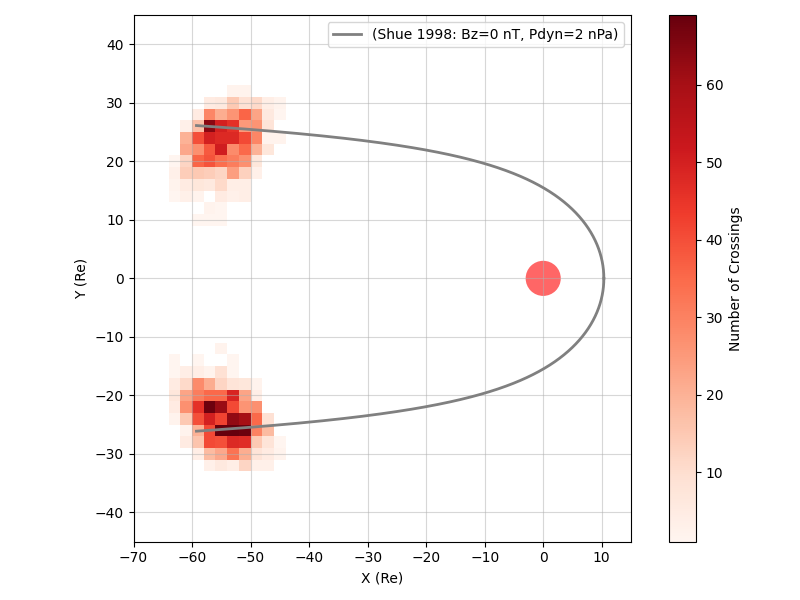

In [58]:
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
%matplotlib widget

# Combine predicted positions from both spacecraft
predicted_positions_combined = np.vstack([predicted_positions_B_no_outliers, predicted_positions_C_no_outliers])

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
ylim = [-45, 45]

# Create 2x2 Re grid
x_edges = np.arange(xlim[0], xlim[1] + 2, 2)
y_edges = np.arange(ylim[0], ylim[1] + 2, 2)

# Calculate density histogram using combined positions
xp, yp = predicted_positions_combined[:, 0], predicted_positions_combined[:, 1]
density, x_edges, y_edges = np.histogram2d(xp, yp, bins=[x_edges, y_edges])

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges[:-1] + 1, y_edges[:-1] + 1)  # Center of each bin

# Mask zero values to make them transparent
density_masked = np.ma.masked_where(density.T == 0, density.T)

# Create a truncated colormap using only the brightest 90% of YlOrRd
import matplotlib.pyplot as plt

# Get the original colormap
original_cmap = plt.cm.YlOrRd
# Create truncated colormap from 10% to 100% (brightest 90%)
truncated_cmap = LinearSegmentedColormap.from_list(
        'truncated_YlOrRd', 
        original_cmap(np.linspace(0.1, 1.0, 256))
)

# Plot density as colored mesh with truncated colormap
im = ax.pcolormesh(x_edges, y_edges, density_masked, 
                                   cmap='Reds', alpha=1, shading='auto')
cbar = plt.colorbar(im, ax=ax, label='Number of Crossings')

# Magnetopause curve (upper and lower halves)
mp_x, mp_y = shue_magnetopause_xy(Bz_nT=0, Pdyn_nPa=2)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_y[mask],  lw=2, color='gray',
                label='(Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_y[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='red',
                           alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Add hover functionality
def format_coord(x, y):
        # Find which bin the coordinates fall into
        x_idx = np.digitize(x, x_edges) - 1
        y_idx = np.digitize(y, y_edges) - 1
        
        # Check bounds
        if 0 <= x_idx < len(x_edges)-1 and 0 <= y_idx < len(y_edges)-1:
                count = density[x_idx, y_idx]
                return f'X={x:.1f}, Y={y:.1f}, Count={count:.0f}'
        else:
                return f'X={x:.1f}, Y={y:.1f}'

ax.format_coord = format_coord

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.grid(True, alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

20-Oct-25 10:56:16: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(

20-Oct-25 10:56:16: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\shue_model.py:90: RuntimeWarning: divide by zero encountered in divide
  R = r0 * (2.0 / (1.0 + np.cos(theta)))**alpha



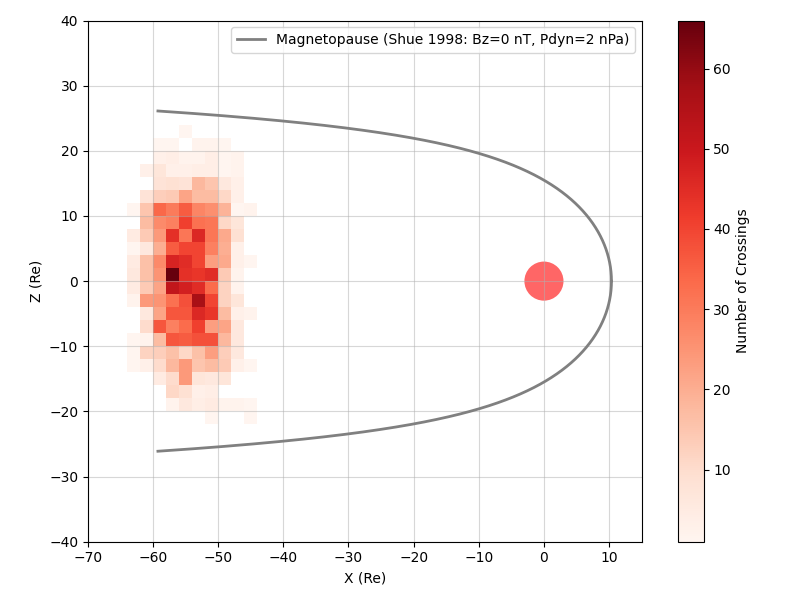

In [59]:
from matplotlib.patches import Circle
import matplotlib.colors as colors
predicted_positions_combined = np.vstack([predicted_positions_B_no_outliers, predicted_positions_C_no_outliers])

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
zlim = [-40, 40]

# Create 2x2 Re grid
x_edges = np.arange(xlim[0], xlim[1] + 2, 2)
z_edges = np.arange(zlim[0], zlim[1] + 2, 2)

# Calculate density histogram
xp, zp = predicted_positions_combined[:, 0], predicted_positions_combined[:, 2]
density, x_edges, z_edges = np.histogram2d(xp, zp, bins=[x_edges, z_edges])

# Create meshgrid for plotting
X, Z = np.meshgrid(x_edges[:-1] + 1, z_edges[:-1] + 1)  # Center of each bin

# Mask zero values to make them transparent
density_masked = np.ma.masked_where(density.T == 0, density.T)

# Plot density as colored mesh
im = ax.pcolormesh(x_edges, z_edges, density_masked, 
                                   cmap='Reds', alpha=1, shading='flat')
cbar = plt.colorbar(im, ax=ax, label='Number of Crossings')

# Add hover functionality
def format_coord(x, z):
        # Find which bin the coordinates fall into
        x_idx = np.digitize(x, x_edges) - 1
        z_idx = np.digitize(z, z_edges) - 1
        
        # Check bounds
        if 0 <= x_idx < len(x_edges)-1 and 0 <= z_idx < len(z_edges)-1:
                count = density[x_idx, z_idx]
                return f'X={x:.1f}, Z={z:.1f}, Count={count:.0f}'
        else:
                return f'X={x:.1f}, Z={z:.1f}'

ax.format_coord = format_coord

# Magnetopause curve (upper and lower halves)
mp_x, mp_z = shue_magnetopause_xz(Bz_nT=0.0, Pdyn_nPa=2.0)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_z[mask],  lw=2, color='gray',
                label='Magnetopause (Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_z[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='red',
                           alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Z (Re)')
ax.grid(True, alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

17-Oct-25 17:26:02: C:\Users\ianma\AppData\Local\Temp\ipykernel_26152\668062589.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df_crossings_filtered.groupby('year').apply(remove_outliers_iqr).reset_index(drop=True)

17-Oct-25 17:26:02: C:\Users\ianma\AppData\Local\Temp\ipykernel_26152\668062589.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(boxplot_data, labels=sorted(df_no_outliers['year'].unique()), patch_artist=True)



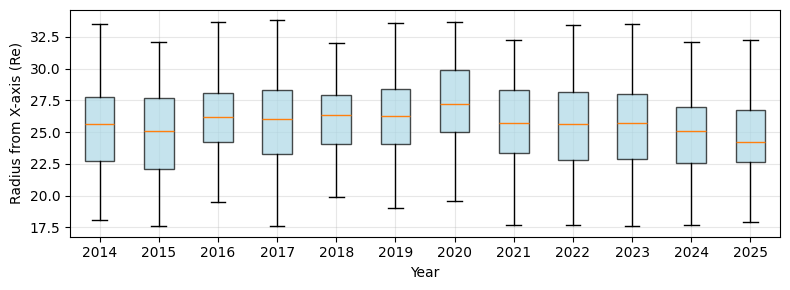

Yearly Statistics with outliers removed (Excluding 2013):
    year  median     q1     q3  count   iqr
0   2014   25.64  22.69  27.73    203  5.04
1   2015   25.11  22.09  27.65    274  5.55
2   2016   26.20  24.20  28.08    206  3.87
3   2017   26.03  23.29  28.28    286  4.99
4   2018   26.34  24.03  27.93    199  3.90
5   2019   26.27  24.03  28.36    229  4.33
6   2020   27.24  24.98  29.91    222  4.93
7   2021   25.70  23.39  28.34    232  4.96
8   2022   25.63  22.80  28.19    237  5.38
9   2023   25.70  22.86  27.98    230  5.12
10  2024   25.10  22.58  26.96    199  4.39
11  2025   24.25  22.66  26.72    154  4.05

Outliers removed per year:
2014: 0 outliers removed
2015: 0 outliers removed
2016: 2 outliers removed
2017: 0 outliers removed
2018: 0 outliers removed
2019: 0 outliers removed
2020: 0 outliers removed
2021: 0 outliers removed
2022: 0 outliers removed
2023: 0 outliers removed
2024: 0 outliers removed
2025: 1 outliers removed

Date range: 2014-01-13 01:21:40.451800020

In [220]:
%matplotlib inline

# Divide the predicted crossings per year without overlap, calculate the median and IQR of the radius from the X axis, and plot across time

# Combine all predicted crossings with timestamps
all_times = np.concatenate([predicted_crossing_times_norm_B_no_outliers, predicted_crossing_times_norm_C_no_outliers])
all_positions = np.vstack([predicted_positions_B_no_outliers, predicted_positions_C_no_outliers])

# Calculate radius from X axis (sqrt(Y^2 + Z^2))
radii = np.sqrt(all_positions[:, 1]**2 + all_positions[:, 2]**2)

# Create DataFrame for easier analysis
df_crossings = pd.DataFrame({
    'time': all_times,
    'x': all_positions[:, 0],
    'y': all_positions[:, 1], 
    'z': all_positions[:, 2],
    'radius_from_x': radii
})

# Convert to pandas datetime for easier manipulation
df_crossings['datetime'] = pd.to_datetime(df_crossings['time'])

# Extract year directly from datetime (no overlap)
df_crossings['year'] = df_crossings['datetime'].dt.year

# Filter out 2013
df_crossings_filtered = df_crossings[df_crossings['year'] > 2013]

# Remove outliers using boxplot standards (IQR method) for each year
def remove_outliers_iqr(group):
    Q1 = group['radius_from_x'].quantile(0.25)
    Q3 = group['radius_from_x'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['radius_from_x'] >= lower_bound) & (group['radius_from_x'] <= upper_bound)]

# Apply outlier removal for each year
df_no_outliers = df_crossings_filtered.groupby('year').apply(remove_outliers_iqr).reset_index(drop=True)

# Group by year and calculate median and IQR for cleaned data
yearly_stats = df_no_outliers.groupby('year')['radius_from_x'].agg([
    'median', 
    lambda x: x.quantile(0.25),  # Q1
    lambda x: x.quantile(0.75),  # Q3
    'count'
]).reset_index()

# Rename columns for clarity
yearly_stats.columns = ['year', 'median', 'q1', 'q3', 'count']
yearly_stats['iqr'] = yearly_stats['q3'] - yearly_stats['q1']

# Create boxplot data for each year
boxplot_data = [df_no_outliers[df_no_outliers['year'] == year]['radius_from_x'].values 
                for year in sorted(df_no_outliers['year'].unique())]

# Create the plots
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 3))

# Full boxplot
bp = ax1.boxplot(boxplot_data, labels=sorted(df_no_outliers['year'].unique()), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('Radius from X-axis (Re)')
# ax1.set_title('Full Boxplot: Distance from X-axis vs Year (Outliers Removed, Excluding 2013)')
ax1.grid(True, alpha=0.3)

# # Plot median radius with error bars (IQR)
# ax2.plot(yearly_stats['year'], yearly_stats['median'], 
#             marker='o', linewidth=2, color='blue')
# ax2.set_xlabel('Year')
# ax2.set_ylabel('Radius from X-axis (Re)')
# ax2.set_title('Median Distance from X-axis vs Year (Outliers Removed, Excluding 2013)')
# ax2.grid(True, alpha=0.3)

# # Plot number of crossings per year (after outlier removal)
# ax3.bar(yearly_stats['year'], yearly_stats['count'], alpha=0.7, color='orange')
# ax3.set_xlabel('Year') 
# ax3.set_ylabel('Number of Crossings')
# ax3.set_title('Number of Predicted Crossings per Year (Outliers Removed, Excluding 2013)')
# ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the statistics table
print("Yearly Statistics with outliers removed (Excluding 2013):")
print(yearly_stats.round(2))

# Print outlier removal summary
original_counts = df_crossings_filtered.groupby('year')['radius_from_x'].count()
cleaned_counts = df_no_outliers.groupby('year')['radius_from_x'].count()
outliers_removed = original_counts - cleaned_counts

print("\nOutliers removed per year:")
for year in sorted(df_crossings_filtered['year'].unique()):
    print(f"{year}: {outliers_removed.get(year, 0)} outliers removed")

# Print date range for verification
print(f"\nDate range: {df_no_outliers['datetime'].min()} to {df_no_outliers['datetime'].max()}")


In [77]:
yearly_pressure_avg.values

array([2.10315179, 2.28328344, 2.1063749 , 2.28471128, 1.92240789,
       1.78452733, 1.39494366, 1.96696903, 2.16190548, 1.87717098,
       2.03792222, 2.38033119])

In [83]:
import math

# 2013   1  0  -0.2  1.60
# 2014   1  0   0.2  1.85
# 2015   1  0  -0.1  2.43
# 2016   1  0  -0.0  2.23
# 2017   1  0  -0.1  2.19
# 2018   1  0  -0.1  1.94
# 2019   1  0  -0.2  1.70
# 2020   1  0  -0.2  1.52
# 2021   1  0  -0.1  1.84
# 2022   1  0  -0.0  1.86
# 2023   1  0  -0.2  1.93
# 2024   1  0  -0.1  2.27
# 2025   1  0  -0.1  2.58

# Group average solar wind dynamic pressures 
# Group pressures by year and calculate averages
combined_df = pd.DataFrame({
    'time': predicted_times_combined,
    'pressure': pressures
})
combined_df['datetime'] = pd.to_datetime(combined_df['time'])
combined_df['year'] = combined_df['datetime'].dt.year

# Filter out 2013 and calculate yearly averages
yearly_pressure_avg = combined_df[combined_df['year'] > 2013].groupby('year')['pressure'].mean()


# Average X coordinate of crossings
x_B_mean = np.mean(predicted_positions_B_no_outliers[:, 0])
x_C_mean = np.mean(predicted_positions_C_no_outliers[:, 0])

total_crossings = len(predicted_positions_B_no_outliers) + len(predicted_positions_C_no_outliers)

x_mean = x_B_mean * len(predicted_positions_B_no_outliers) / total_crossings + x_C_mean * len(predicted_positions_C_no_outliers) / total_crossings

Bz = [0.2, -0.1, 0.0, -0.1, -0.1, -0.2, -0.2, -0.1, 0.0, -0.2, -0.1, -0.1]  # nT
Pdyn = [1.85, 2.43, 2.23, 2.19, 1.94, 1.70, 1.52, 1.84, 1.86, 1.93, 2.27, 2.58]  # nPa

def r0_shue(Pdyn, Bz):
    # Shue et al. 1998: r0 = (10.22 + 1.29*tanh[0.184*(Bz+8.14)]) * Pdyn**(-1/6.6)
    return (10.22 + 1.29*math.tanh(0.184*(Bz+8.14))) * (Pdyn ** (-1/6.6))

# Calculate r0 for each year
r0_values = [shue_radius_at_x(-54.5,  Bz[i], Pdyn[i]) for i in range(len(Bz))]
r0_values_Themis =  [shue_radius_at_x(-54.5,  Bz[i], yearly_pressure_avg.values[i]) for i in range(len(Bz))]


x_mean

-54.52360753344845

19-Oct-25 17:48:19: C:\Users\ianma\AppData\Local\Temp\ipykernel_31944\3713279325.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(yearly_stats['year'], r0_values_Themis, 'r-',color='red', marker='s', linewidth=1.5, alpha=1, markersize=5, label='(Shue 1998), -54 Re, ARTEMIS avg Pdyn')



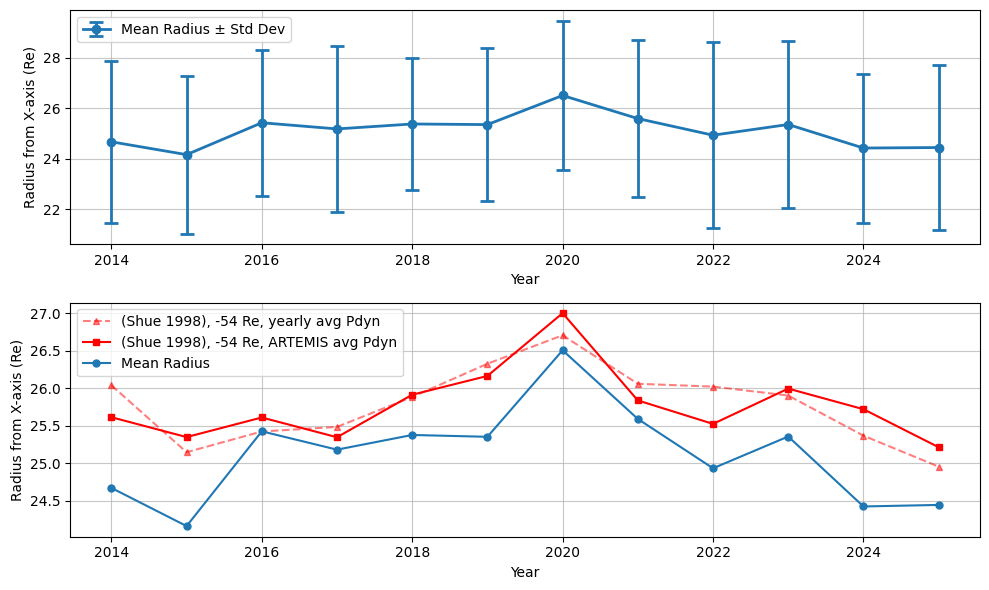

Yearly Statistics (Excluding 2013):
    year   mean   std  count
0   2014  24.67  3.21    235
1   2015  24.16  3.13    299
2   2016  25.43  2.89    221
3   2017  25.18  3.29    287
4   2018  25.38  2.60    212
5   2019  25.35  3.02    249
6   2020  26.51  2.96    254
7   2021  25.59  3.09    261
8   2022  24.93  3.68    237
9   2023  25.36  3.30    222
10  2024  24.42  2.95    174
11  2025  24.44  3.28    150

Date range: 2014-01-13 01:22:31.064086058 to 2025-07-12 16:27:08.990614850


In [122]:
%matplotlib inline

# Divide the predicted crossings per year without overlap, calculate the average and std of the radius from the X axis, and plot across time

# Combine all predicted crossings with timestamps
all_times = np.concatenate([predicted_crossing_times_norm_B_no_outliers, predicted_crossing_times_norm_C_no_outliers])
all_positions = np.vstack([predicted_positions_B_no_outliers, predicted_positions_C_no_outliers])

# Calculate radius from X axis (sqrt(Y^2 + Z^2))
radii = np.sqrt(all_positions[:, 1]**2 + all_positions[:, 2]**2)

# Create DataFrame for easier analysis
df_crossings = pd.DataFrame({
    'time': all_times,
    'x': all_positions[:, 0],
    'y': all_positions[:, 1], 
    'z': all_positions[:, 2],
    'radius_from_x': radii
})

# Convert to pandas datetime for easier manipulation
df_crossings['datetime'] = pd.to_datetime(df_crossings['time'])

# Extract year directly from datetime (no overlap)
df_crossings['year'] = df_crossings['datetime'].dt.year

# Filter out 2013
df_crossings_filtered = df_crossings[df_crossings['year'] > 2013]

# Group by year
yearly_stats = df_crossings_filtered.groupby('year')['radius_from_x'].agg(['mean', 'std', 'count']).reset_index()

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Plot mean radius with error bars (std)
ax1.errorbar(yearly_stats['year'], yearly_stats['mean'], yerr=yearly_stats['std'], 
            marker='o', capsize=5, capthick=2, linewidth=2, label='Mean Radius ± Std Dev')
ax1.set_xlabel('Year')
ax1.set_ylabel('Radius from X-axis (Re)')
ax1.grid(True, alpha=0.7)

# Second axis for Shue model r0 values
ax2.plot(yearly_stats['year'], r0_values, '--', color='red',  marker='^', linewidth=1.5, markersize=5, alpha=0.5, label='(Shue 1998), -54 Re, yearly avg Pdyn')
ax2.set_ylabel('Radius from X-axis (Re)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

ax2.plot(yearly_stats['year'], r0_values_Themis, 'r-',color='red', marker='s', linewidth=1.5, alpha=1, markersize=5, label='(Shue 1998), -54 Re, ARTEMIS avg Pdyn')
ax2.set_ylabel('Radius from X-axis (Re)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Second axis for r0_values
ax2.plot(yearly_stats['year'], yearly_stats['mean'], marker='o', linewidth=1.5, markersize=5, label='Mean Radius')
ax2.set_xlabel('Year')
ax2.set_ylabel('Radius from X-axis (Re)')
ax2.grid(True, alpha=0.7)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Print the statistics table
print("Yearly Statistics (Excluding 2013):")
print(yearly_stats.round(2))

# Print date range for verification
print(f"\nDate range: {df_crossings_filtered['datetime'].min()} to {df_crossings_filtered['datetime'].max()}")


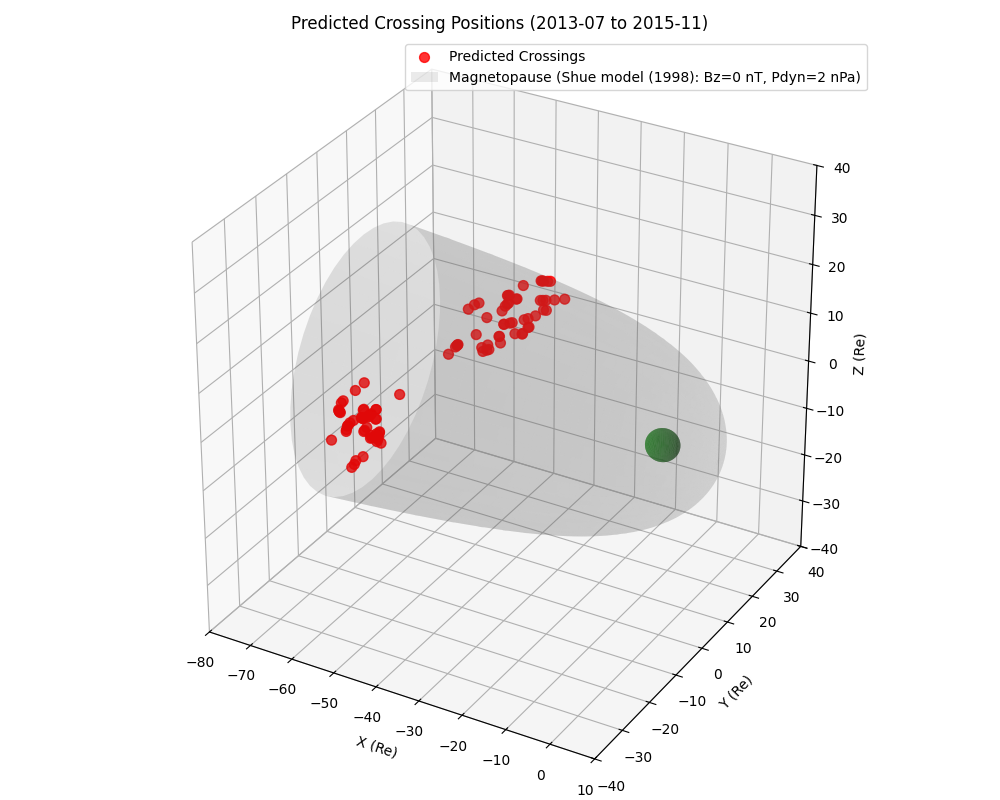

In [181]:
%matplotlib widget
plt.close()
import matplotlib.lines as mlines
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create Earth sphere with radius of 1 Re
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)

# Plot predicted positions
ax.scatter(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], 
           c='red', s=50, alpha=0.8, label='Predicted Crossings')

# Plot spacecraft trajectory for each timerange
# for pos_in_range in timeranges_pos:
#     ax.plot(pos_in_range[:, 0], pos_in_range[:, 1], pos_in_range[:, 2], 
#             c='black', alpha=0.1)

# Set labels
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.set_zlabel('Z (Re)')

# Set equal aspect ratio for all axes
box_aspect = [1,1,1]  # Different aspect ratio
ax.set_box_aspect(box_aspect)

# Set axis limits based on data range
xlim = [-80, 15]
ylim = [-40, 40]
zlim = [-40, 40]
ax.set_xlim([-80, 10])
ax.set_ylim([-40, 40])
ax.set_zlim([-40, 40])

# Build the magnetopause surface (using your axis limits)
mp_x, mp_y, mp_z = shue_magnetopause_surface(Bz_nT=0.0, Pdyn_nPa=2.0,
                                             Xmin=-60, Xmax=xlim[1])

# Apply the same visual x-stretch you used for the Earth sphere
x_stretch = (box_aspect[1] / box_aspect[0]) * ((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]))
mp_x_plot = mp_x * x_stretch

# Draw the surface
ax.plot_surface(mp_x_plot, mp_y, mp_z, alpha=0.15, linewidth=0, color='gray', label='Magnetopause (Shue model (1998): Bz=0 nT, Pdyn=2 nPa)')

# Add a legend entry for the surface (plot_surface doesn't auto-legend)
mp_proxy = mlines.Line2D([], [], color='gray', lw=6, alpha=0.6,
                         label='Magnetopause (Shue model: Bz=0 nT, Pdyn=2 nPa)')
handles, labels = ax.get_legend_handles_labels()
handles.append(mp_proxy)
labels.append(mp_proxy.get_label())
ax.legend(handles, labels)

stretch = box_aspect[1]/ box_aspect[0]  # Stretch factor for x-axis

# Earth radius in Re (Earth radii) - 1 Re
earth_radius = 3.0
earth_x = earth_radius * np.outer(np.cos(u), np.sin(v))*stretch*(np.diff(xlim)/np.diff(ylim))
earth_y = earth_radius * np.outer(np.sin(u), np.sin(v))
earth_z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot Earth as a blue sphere
ax.plot_surface(earth_x, earth_y, earth_z, color='green', alpha=0.6)

ax.legend()
ax.set_title('Predicted Crossing Positions (2013-07 to 2015-11)')
plt.tight_layout()
plt.show()

03-Oct-25 00:03:13: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\shue_model.py:90: RuntimeWarning: divide by zero encountered in divide
  R = r0 * (2.0 / (1.0 + np.cos(theta)))**alpha



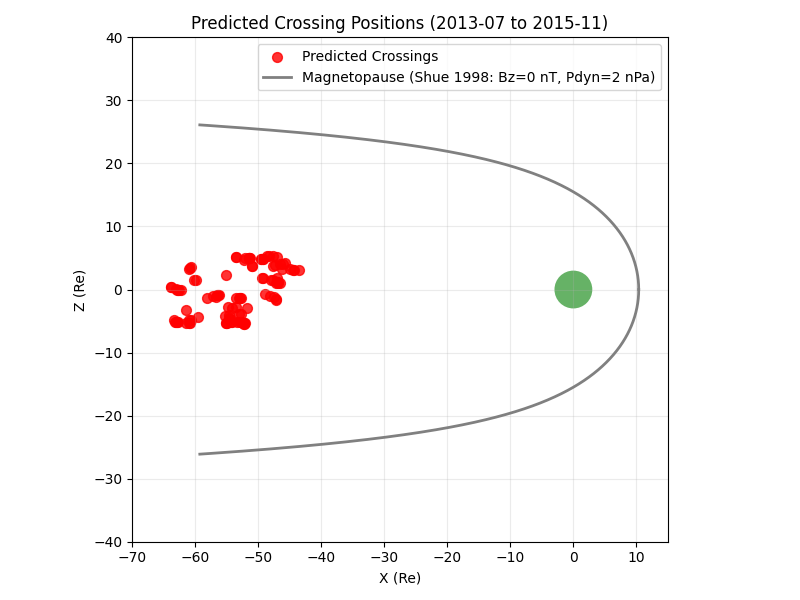

In [437]:
from matplotlib.patches import Circle

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
zlim = [-40, 40]

# (Optional) If you prefer only points near the X–Z plane, filter by |Y|<=delta.
# delta = 2.0
# pred_mask = np.abs(predicted_positions[:, 1]) <= delta
# true_mask = np.abs(true_positions[:, 1]) <= delta
# xp, zp = predicted_positions[pred_mask, 0], predicted_positions[pred_mask, 2]
# xt, zt = true_positions[true_mask, 0], true_positions[true_mask, 2]
# Otherwise, just project by dropping Y:
xp, zp = predicted_positions[:, 0], predicted_positions[:, 2]

# Points (X vs Z)
ax.scatter(xp, zp, c='red', s=50, alpha=0.8, label='Predicted Crossings')

# Magnetopause curve (upper and lower halves)
mp_x, mp_z = shue_magnetopause_xz(Bz_nT=0.0, Pdyn_nPa=2.0)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_z[mask],  lw=2, color='gray',
        label='Magnetopause (Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_z[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='green',
               alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Z (Re)')
ax.set_title('Predicted Crossing Positions (2013-07 to 2015-11)')
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

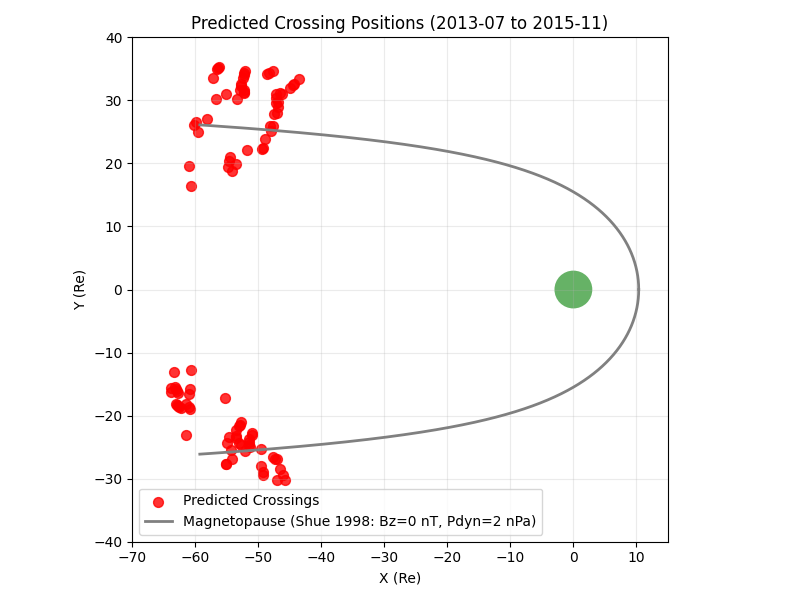

In [438]:
from matplotlib.patches import Circle

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
ylim = [-40, 40]

# (Optional) If you prefer only points near the X–Z plane, filter by |Y|<=delta.
# delta = 2.0
# pred_mask = np.abs(predicted_positions[:, 1]) <= delta
# true_mask = np.abs(true_positions[:, 1]) <= delta
# xp, zp = predicted_positions[pred_mask, 0], predicted_positions[pred_mask, 2]
# xt, zt = true_positions[true_mask, 0], true_positions[true_mask, 2]
# Otherwise, just project by dropping Y:
xp, yp = predicted_positions[:, 0], predicted_positions[:, 1]

# Points (X vs Z)
ax.scatter(xp, yp, c='red', s=50, alpha=0.8, label='Predicted Crossings')

# Magnetopause curve (upper and lower halves)
mp_x, mp_y = shue_magnetopause_xy(Bz_nT=0.0, Pdyn_nPa=2.0)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_y[mask],  lw=2, color='gray',
        label='Magnetopause (Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_y[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='green',
               alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.set_title('Predicted Crossing Positions (2013-07 to 2015-11)')
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

In [167]:
predicted_times_numeric[0].astype('datetime64[ns]')

numpy.datetime64('2013-08-17T16:12:58.879218902')

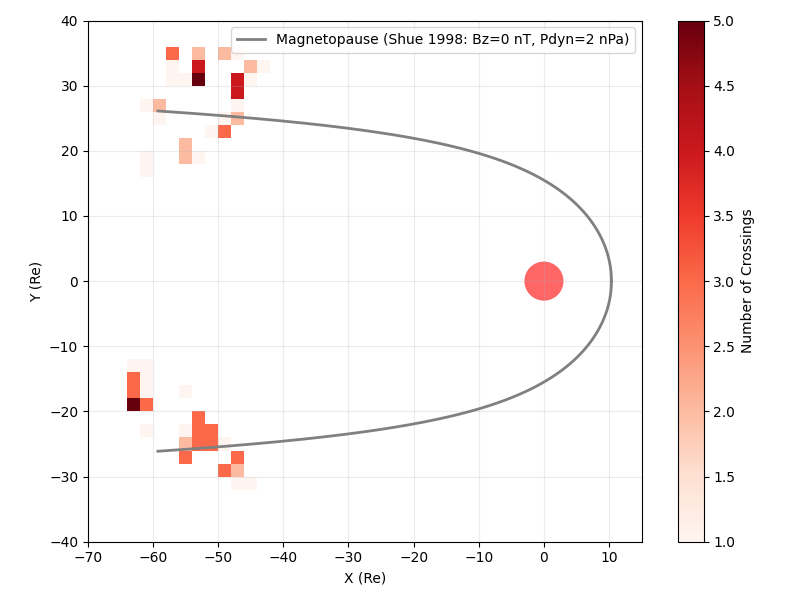

In [439]:
from matplotlib.patches import Circle
import matplotlib.colors as colors

# --- Figure ---
fig, ax = plt.subplots(figsize=(8,6))

# Axis limits (match your 3D view)
xlim = [-70, 15]
ylim = [-40, 40]

# Create 2x2 Re grid
x_edges = np.arange(xlim[0], xlim[1] + 2, 2)
y_edges = np.arange(ylim[0], ylim[1] + 2, 2)

# Calculate density histogram
xp, yp = predicted_positions[:, 0], predicted_positions[:, 1]
density, x_edges, y_edges = np.histogram2d(xp, yp, bins=[x_edges, y_edges])

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges[:-1] + 1, y_edges[:-1] + 1)  # Center of each bin

# Mask zero values to make them transparent
density_masked = np.ma.masked_where(density.T == 0, density.T)

# Plot density as colored mesh
im = ax.pcolormesh(x_edges, y_edges, density_masked, 
                   cmap='Reds', alpha=1, shading='auto')
cbar = plt.colorbar(im, ax=ax, label='Number of Crossings')

# Magnetopause curve (upper and lower halves)
mp_x, mp_y = shue_magnetopause_xy(Bz_nT=0.0, Pdyn_nPa=2.0)
mask = (mp_x >= -60) & (mp_x <= xlim[1])  # match your 3D windowing
ax.plot(mp_x[mask],  mp_y[mask],  lw=2, color='gray',
        label='Magnetopause (Shue 1998: Bz=0 nT, Pdyn=2 nPa)')
ax.plot(mp_x[mask], -mp_y[mask], lw=2, color='gray')

# Earth as a filled circle at the origin
earth_radius = 3.0  # set to 1.0 if you want unit Earth
earth = Circle((0.0, 0.0), radius=earth_radius, facecolor='red',
               alpha=0.6, edgecolor='none')
ax.add_patch(earth)

# Cosmetics
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (Re)')
ax.set_ylabel('Y (Re)')
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()